VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a Variational RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from libs.vrnn_lib import seed_everything, VRNN
from libs.vrnn_lib import loss_function, train
from libs.vrnn_lib import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib import plot_losses, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel:

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- pas d'extracteurs de features sur $x$ et $z$

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation générique se simplifie dans le cas du DKF en :

\begin{align}
\mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T \mathbb{E}_{q_\phi(z_t \vert x_{1:T})} \log(p_{\theta_x}(x_t \vert z_t)) -
\sum_{t=1}^T \mathbb{E}_{q_\phi(z_{t-1} \vert x_{1:T})} \text{D}_{\text{KL}} \left[ q_\phi(z_t \vert z_{t-1}, x_{t:T}) \vert\vert 
p_{\theta_z}(z_t \vert z_{t-1}) \right]
\end{align}

Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

# Toy Case : Data Generation for Time Series Forecasting

In [6]:
n_steps = 25
n_ahead = 10
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [7]:
s = generate_time_series(n_series, n_steps+n_ahead)

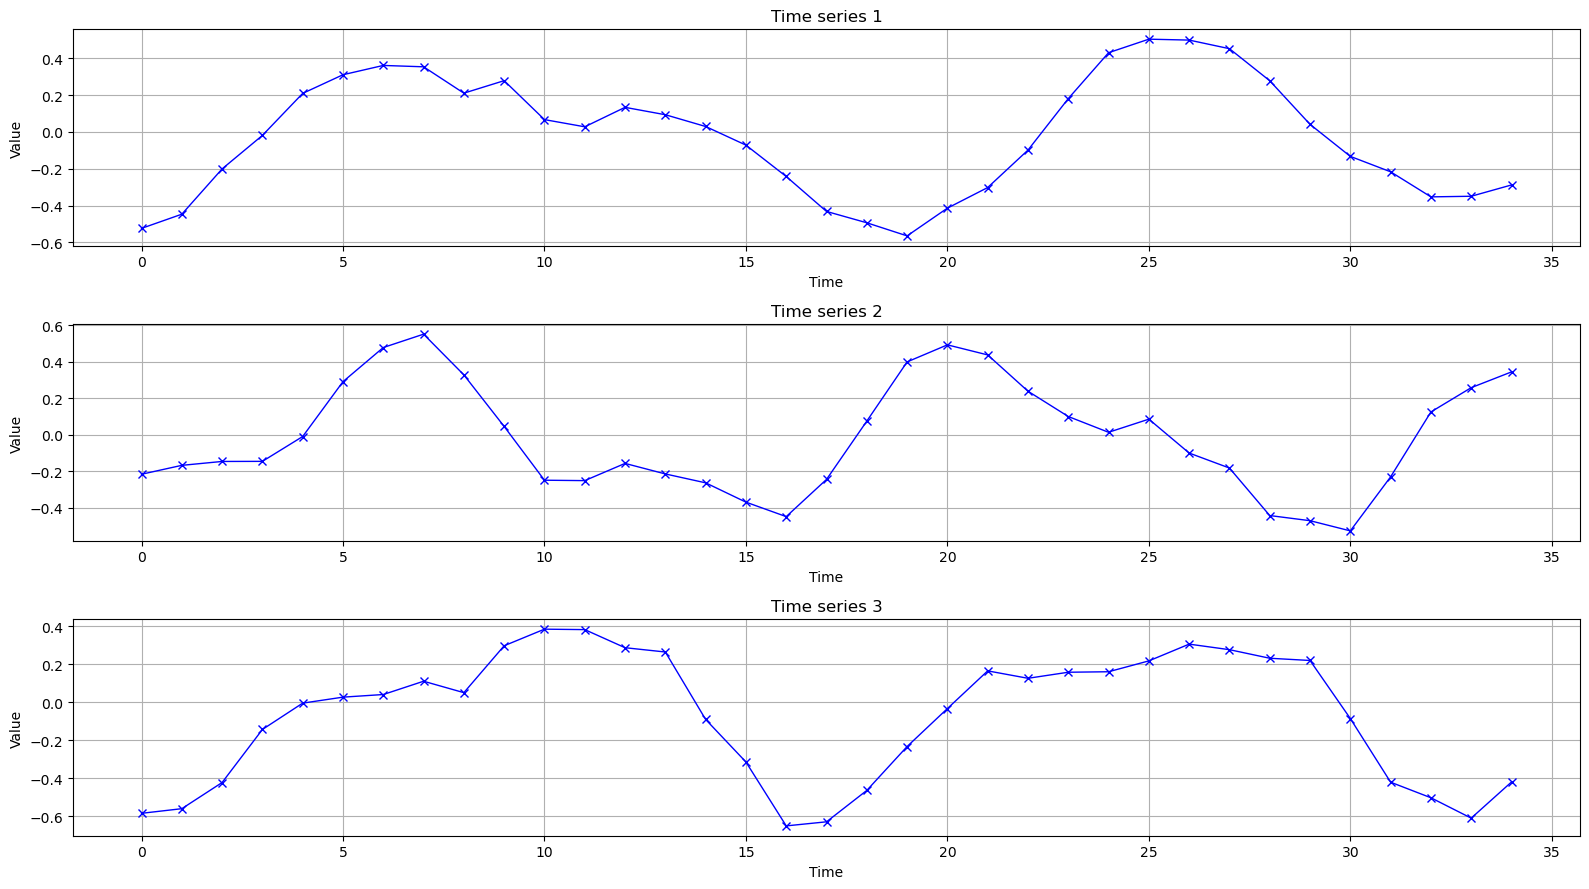

In [8]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [9]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 25)
y_train shape: (80, 10)
X_valid shape: (20, 25)
y_valid shape: (20, 10)


In [10]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [11]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [12]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([16, 50, 1])
output shape: torch.Size([16, 10, 1])


In [14]:
criterion = nn.MSELoss()

In [15]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 100

In [16]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 100 epochs
epoch   10/100, training loss = 6.6298e-02, validation loss = 5.8661e-02
epoch   20/100, training loss = 4.4920e-02, validation loss = 5.3722e-02
epoch   30/100, training loss = 4.4290e-02, validation loss = 4.1623e-02
epoch   40/100, training loss = 3.7992e-02, validation loss = 3.7036e-02
epoch   50/100, training loss = 4.3527e-02, validation loss = 3.8888e-02
epoch   60/100, training loss = 3.4950e-02, validation loss = 2.9665e-02
epoch   70/100, training loss = 3.1440e-02, validation loss = 2.8285e-02
epoch   80/100, training loss = 3.0226e-02, validation loss = 3.2853e-02
epoch   90/100, training loss = 3.2294e-02, validation loss = 3.2495e-02
epoch  100/100, training loss = 2.6364e-02, validation loss = 2.3130e-02


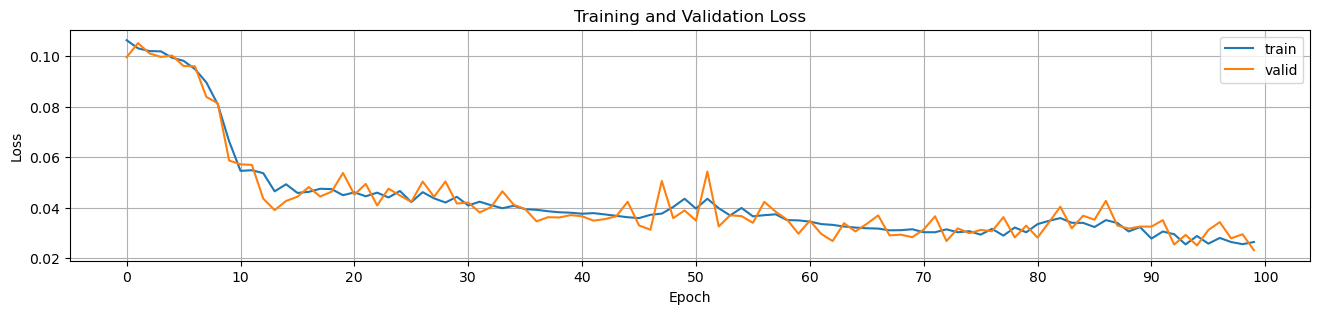

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 10))
ax.set_xticklabels(np.arange(0, num_epochs+1, 10))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [18]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 2.6533e-02


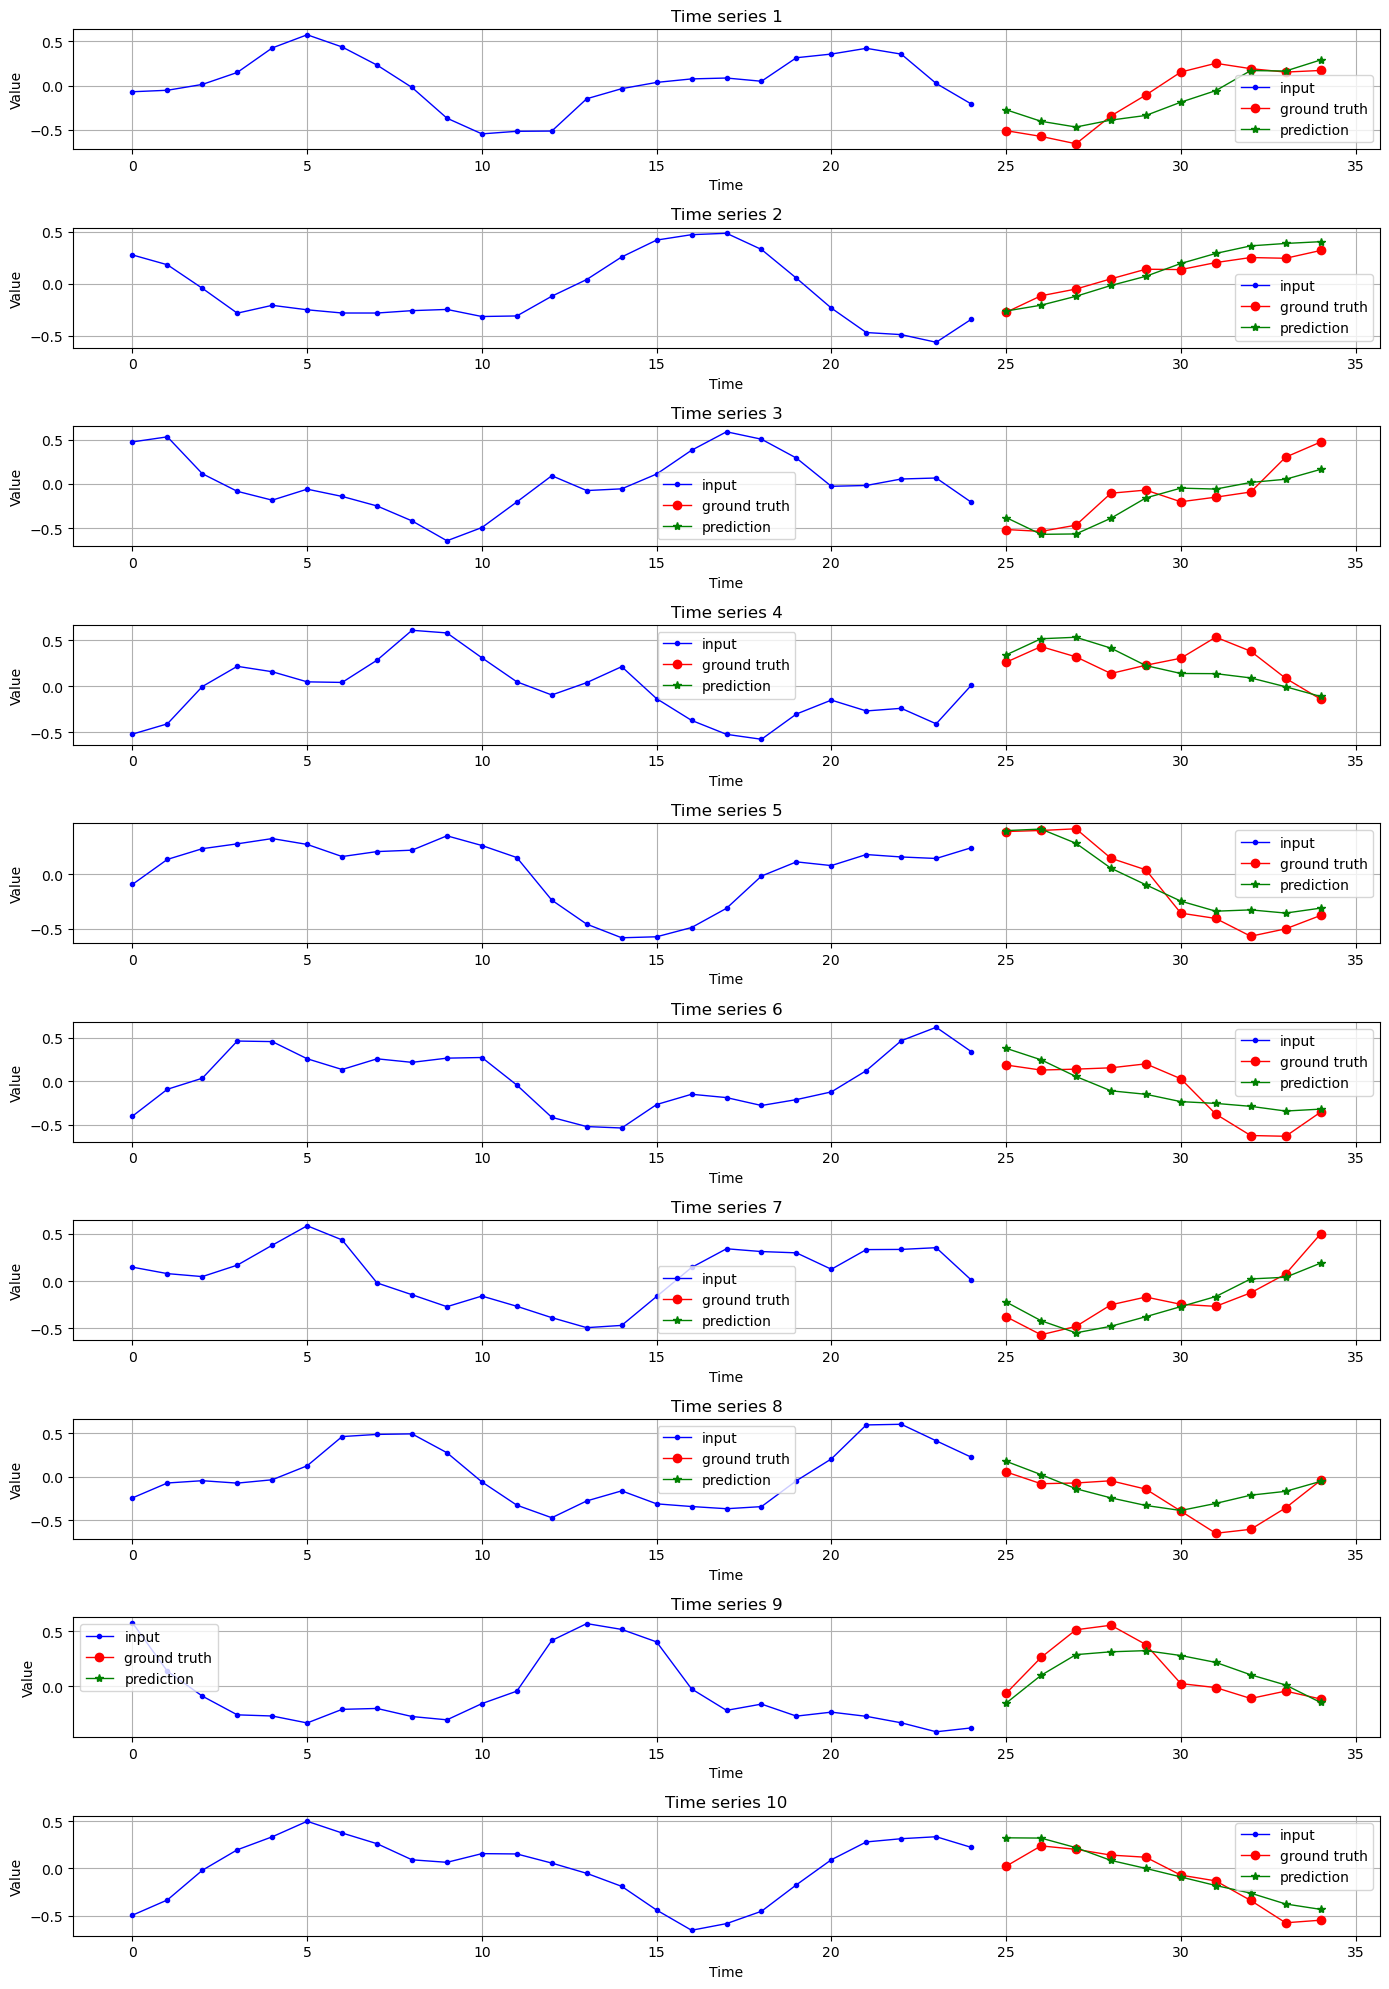

In [19]:
N = 10
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Training VRNN

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/vrnn3.jpg" width="1000"/>
</div>

In [20]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [21]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=1, latent_dim=32)
Bidirectional LSTM (input_size=1, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=1, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_

In [22]:
optimizer = torch.optim.Adam(vrnn.parameters(), lr=1e-3)
loss_fn = loss_function

K = 5

In [23]:
num_epochs = 250
n_displays = 250
display_frequency = int(num_epochs / n_displays)

In [24]:
beta = 1.0

# beta_scheduler = BetaLinearScheduler(
#     beta_start=1e-3,
#     beta_end=1.0,
#     epoch_start=150,
#     epoch_end=200,
#     num_epochs=None
# )

# beta_scheduler = BetaThresholdScheduler(
#     rec_loss_threshold=0.0,
#     beta_start=1e-3,
#     beta_end=1.0,
#     num_epochs=20
# )

# print(beta_scheduler)

In [25]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas = train(
    vrnn, 
    optimizer, 
    loss_fn, 
    num_epochs=num_epochs, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    batch_size=BATCH_SIZE, 
    device=device, 
    beta=beta,
    beta_scheduler=None, 
    display_frequency=display_frequency, 
    K=K
)

Starting training...
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB
Number of epochs: 250
Learning rate: 1.000e-03
Batch size: 16
Beta scheduler: None, beta = 1.000e+00
K = 5
Training set size: 80
Validation set size: 20
Device: cuda


Epoch     1/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.8383e-01, KL Loss: 4.5186e-01, Total Loss: 2.3116e+00 - TEST : Rec Loss: 9.5289e-01, KL Loss: 1.0482e+00, Total Loss: 1.9967e+00
Epoch     2/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.5875e-01, KL Loss: 3.0381e-01, Total Loss: 1.8236e+00 - TEST : Rec Loss: 8.7299e-01, KL Loss: 6.9419e-01, Total Loss: 1.5700e+00
Epoch     3/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.0889e-01, KL Loss: 2.1761e-01, Total Loss: 1.4410e+00 - TEST : Rec Loss: 7.4823e-01, KL Loss: 5.3128e-01, Total Loss: 1.2747e+00
Epoch     4/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 2.6592e-01, KL Loss: 1.4543e-01, Total Loss: 1.1569e+00 - TEST : Rec Loss: 6.5290e-01, KL Loss: 3.3272e-01, Total Loss

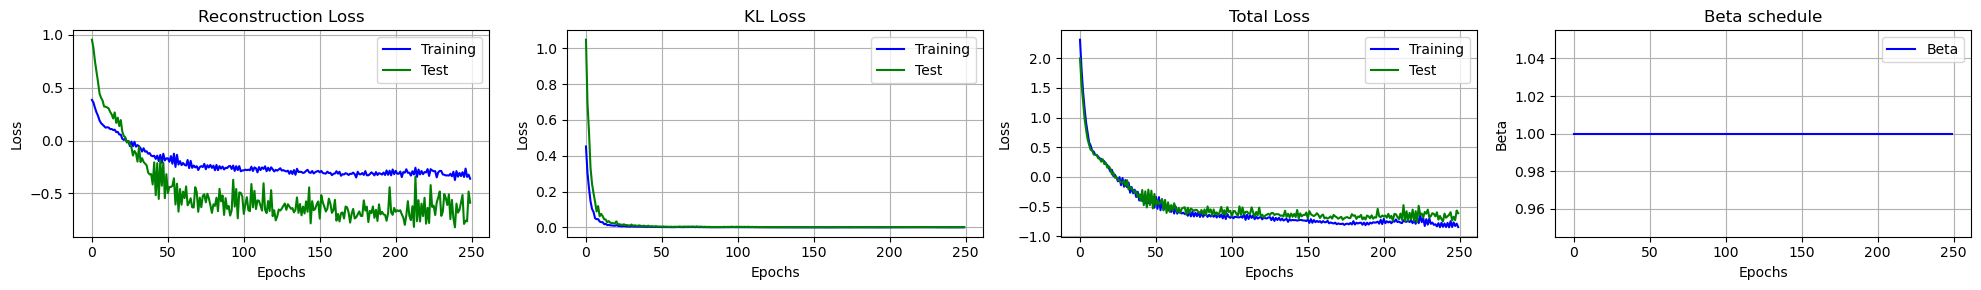

In [29]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas)

# Predictions / Générations

In [30]:
n_ahead = 10

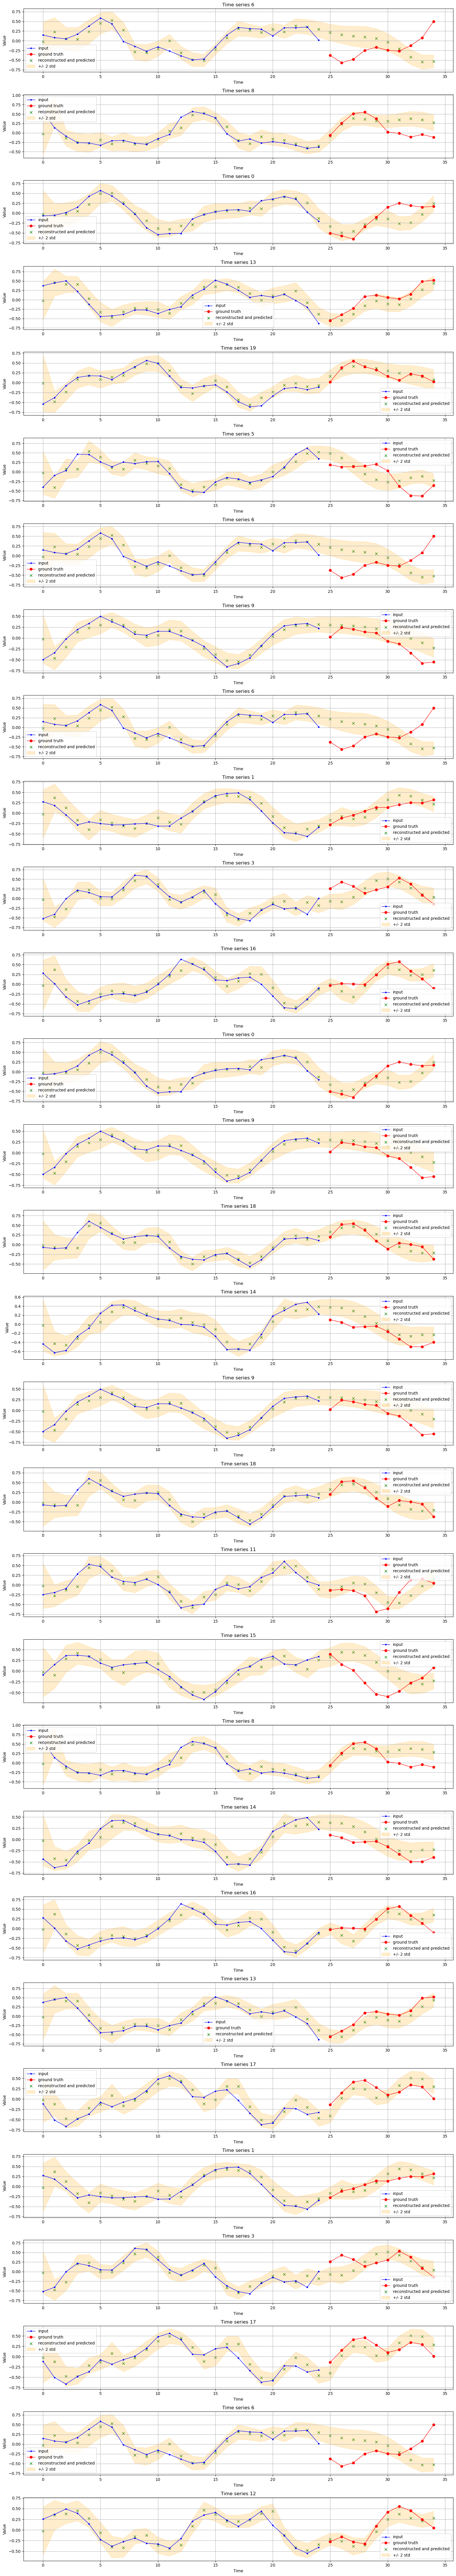

In [31]:
sample_predictions(N_SAMPLES=30, model=vrnn, X_valid=X_valid, y_valid=y_valid, n_steps=n_steps, n_ahead=n_ahead, device=device)